# **TR_2021/02 - Technical report: Correlations between cardiovascular hospitalizations and climatic variables**


|Technical Report ID  |2021/02|
|--|--|
| Title |Correlations between cardiovascular hospitalizations and climatic variables|
| Authors | Júlia De Lázari, Paula Dornhofer|
| Creation Date| 2021-01|


## Databases descriptions

**inputs:** 
- hospitalizações_circulatório.csv: database from SSC (Health Secretay of Campinas - Secretaria de Saúde de Campinas) with hospitalizations due to cardiovascular diseases from 2014 to 2018.
- viracopos_regression.csv: csv file with Viracopos data, already processed and with the regression for humidity. Database with climate data (minimum and maximum temperatures, average pressure, minimum and maximum humidity) from 1983 to 2018.


## Analysis

This report analyse the basic description measures for daily hospitalizations and the correlation between climatic variables (minimum and maximum temperatures, thermal range, average pressure, minimum and maximum humidity, humidity range) and number of hospitalizations due to cardiovascular diseases from 2014 to 2018.

Pearson correlation was used to analyse the correlation between month medians.
The level of significance was 5%.





## **Read and merge data**

In [ ]:
#-------------------------------------------------------------------#
#                       Import libraries                            #
#-------------------------------------------------------------------#
import pandas as pd
import numpy as np
import pylab 
import seaborn as sns
import time
import datetime as dt
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#-------------------------------------------------------------------#
#       Load dataframe - hospitalizations with cardiovascular cid   #
#-------------------------------------------------------------------#
df_hosp = pd.read_csv('hospitalizações_circulatório.csv')
df_hosp = df_hosp.drop(columns = {'Unnamed: 0','Descrição CID','Número Paciente','Hora'})
df_hosp = df_hosp.rename(columns = {'Data':'DATE'}) #rename Data to DATE to merge dataframes

In [ ]:
#-------------------------------------------------------------------#
#           Load dataframe - climatic data from Viracopos           #
#-------------------------------------------------------------------#
df_viracopos =  pd.read_csv('viracopos_regression.csv')
df_viracopos = df_viracopos[df_viracopos['DATE']>='2014-01-01'] #only for the period of time with health data
df_viracopos = df_viracopos.drop(columns = 'Unnamed: 0')
df_viracopos['T_RANGE'] = df_viracopos['TMAX'] - df_viracopos['TMIN'] #create column for thermal range
df_viracopos['H_RANGE'] = df_viracopos['HMAX'] - df_viracopos['HMIN'] #create column for humidity range

In [ ]:
#-------------------------------------------------------------------#
#              Merge health and climate dataframes                  #
#-------------------------------------------------------------------#

df = pd.merge(df_hosp,df_viracopos, on='DATE', how='outer')
df['N_hosp'] = np.where(df['CID'].isnull(),0,df.groupby(['DATE']).DATE.transform('count'))
df = df.drop_duplicates('DATE',keep='first')
df = df.sort_values('DATE')
df['DATE'] = pd.to_datetime(df['DATE'])

## **Basic dispersion measures**

Get the basic dispersion measures and a plot of the number of hospitalizations.

In [ ]:
summary = pd.DataFrame(round(df['N_hosp'].describe(),2))
summary

,N_hosp
count,1826.00
mean,7.05
std,3.19
min,0.00
25%,5.00
50%,7.00
75%,9.00
max,22.00


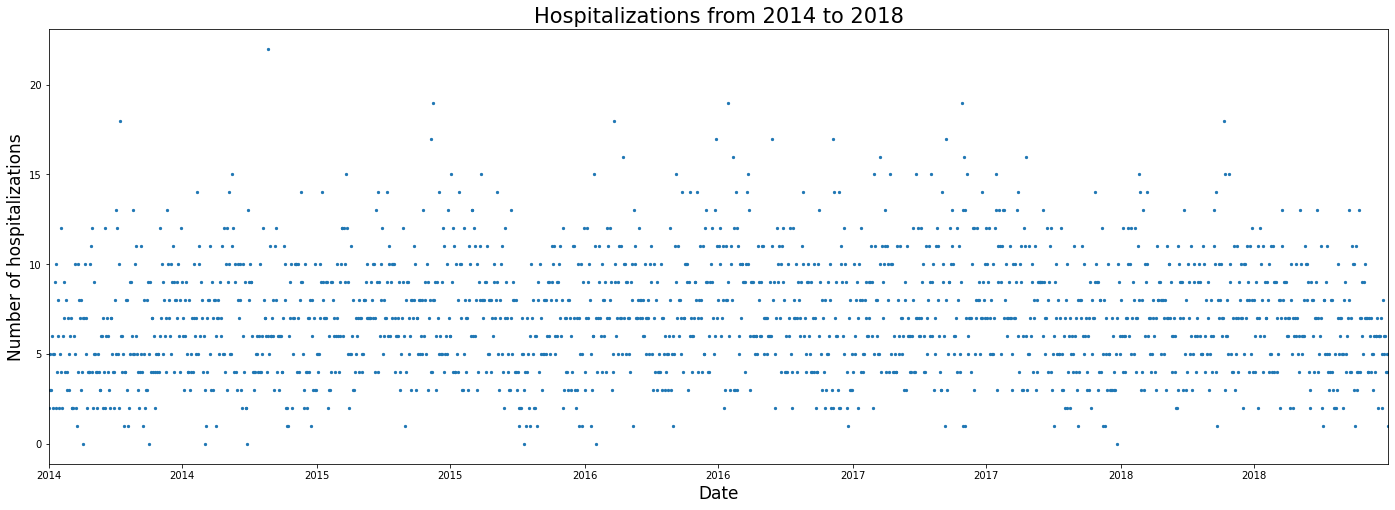

In [ ]:
# Plot
fig1 = plt.figure(figsize=(24, 8))
ax = fig1.add_subplot()
ax.scatter(df['DATE'], df['N_hosp'],color = 'C0',s=5)

# Set title and labels for axes
ax.set_title("Hospitalizations from 2014 to 2018", fontsize = 21)
ax.set_xlabel("Date", fontsize = 17)
ax.set_ylabel("Number of hospitalizations",fontsize = 17)
ax.set_xlim(pd.to_datetime(["2014-01-01", "2018-12-31"]))

date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)

plt.show()

## **Median for each month of the year**

Correlation was found between the median values for each month (median of the 5 years of the database for each month) of climatic parameters and number of hospitalizations.

In [ ]:
# Function to compute Pearson correlation
def get_correlation(df):
  variable = []
  pearson_c = []
  pearson_p = []
  type_c = []
  
  variables_list = ['TMIN','TMAX','T_RANGE','AVGPRESSURE','HMIN','HMAX','H_RANGE']
  titles = ['Minimum temperature (°C)','Maximum temperature (°C)','Thermal range (°C)','Average pressure (HPA)',
            'Minimum humidity (%)','Maximum humidity (%)','Humidity range (%)']

  for i in range(len(variables_list)):
    df_aux = df.dropna(0,subset = [f'{variables_list[i]}'])

    variable.append(titles[i])
    #pearson
    c,p = stats.pearsonr(df_aux[f'{variables_list[i]}'],df_aux['N_hosp'])
    pearson_c.append(round(c,2))
    pearson_p.append(round(p,4))
    
    if (p>0.05):
      type_c.append('-')
    else:
      if (np.abs(c)<0.3):
        type_c.append('negligible')
      elif (0.3<np.abs(c)<0.5):
        type_c.append('weak')
      elif (0.5<np.abs(c)<0.7):
        type_c.append('moderate')
      elif (0.7<np.abs(c)<0.9):
        type_c.append('strong')
      elif (np.abs(c)>0.9):
        type_c.append('very strong')

  table = pd.DataFrame()
  table['Climatic variable'] = titles
  table['Pearson coefficient'] = pearson_c
  table['P'] = pearson_p
  table['Correlation'] = type_c
  
  return table

In [ ]:
#create new column for month
df['Month'] = df['DATE'].dt.strftime('%m')

#create a new dataframe for median values
df2 = pd.DataFrame()

df2['Month']=df['Month']

list_columns = ['N_hosp','TMIN','TMAX','T_RANGE','AVGPRESSURE','HMIN','HMAX','H_RANGE']

for column in list_columns:
  df2[f'{column}'] = df.groupby('Month')[f'{column}'].transform('median')

df2 = df2.drop_duplicates('Month')

In [ ]:
get_correlation(df2)

,Climatic variable,Pearson coefficient,P,Correlation
0,Minimum temperature (°C),-0.59,0.0426,moderate
1,Maximum temperature (°C),-0.54,0.0699,-
2,Thermal range (°C),0.40,0.1971,-
3,Average pressure (HPA),0.63,0.0280,moderate
4,Minimum humidity (%),-0.24,0.4621,-
5,Maximum humidity (%),-0.20,0.5271,-
6,Humidity range (%),0.27,0.3913,-


Plots of median of climatic parameters and number of deaths.

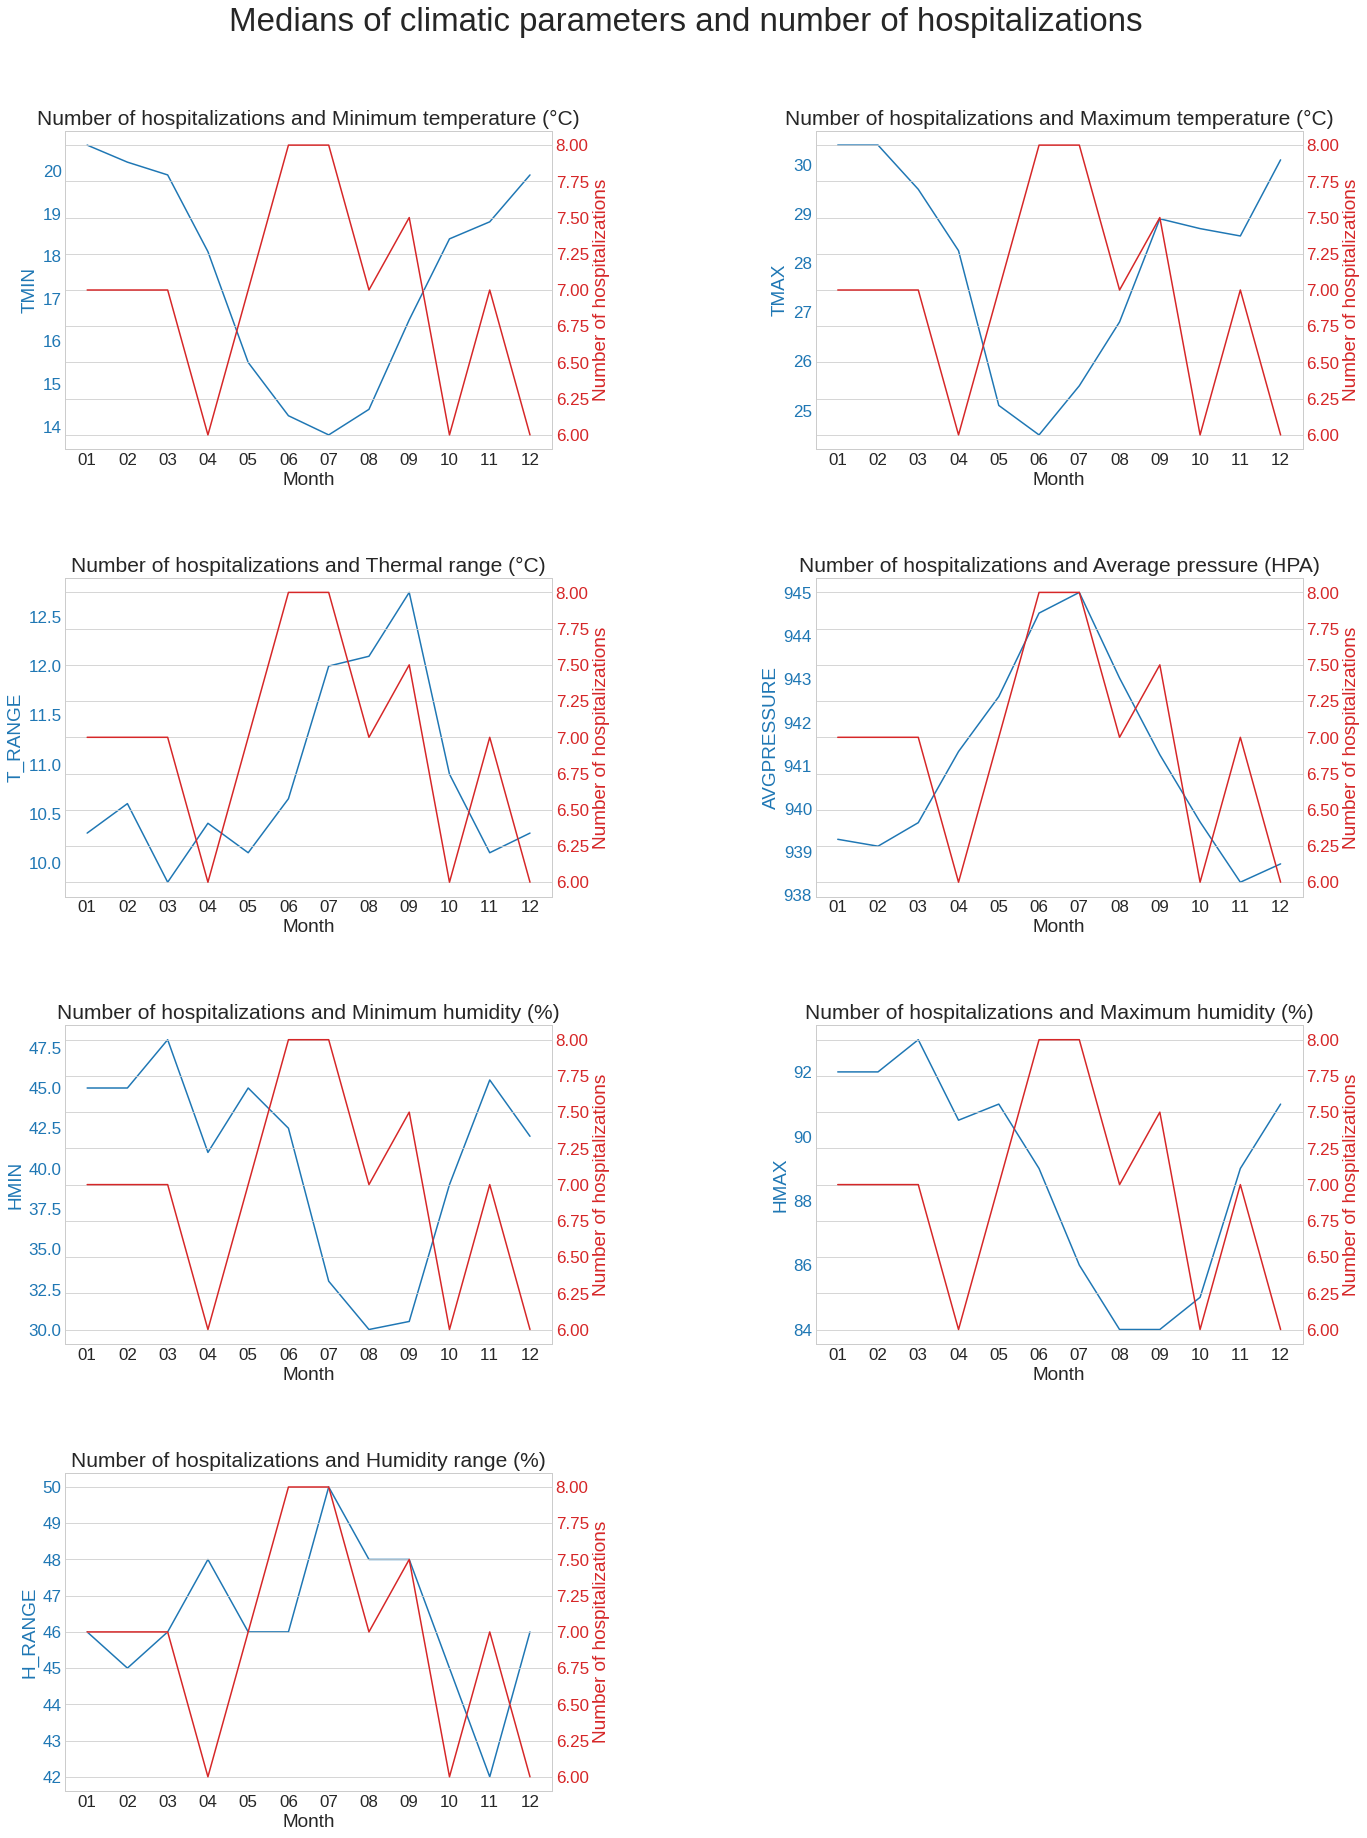

In [ ]:
fig1 = plt.figure(figsize=(21, 25))
plt.style.use('seaborn-whitegrid')
fig1.suptitle('Medians of climatic parameters and number of hospitalizations',fontsize=33,y= 1.03)

variables_list = ['TMIN','TMAX','T_RANGE','AVGPRESSURE','HMIN','HMAX','H_RANGE']
titles = ['Minimum temperature (°C)','Maximum temperature (°C)','Thermal range (°C)','Average pressure (HPA)',
            'Minimum humidity (%)','Maximum humidity (%)','Humidity range (%)']

for i in range(0,len(variables_list)):
  fig1.subplots_adjust(hspace=3, wspace= 2)
  ax1 = fig1.add_subplot(4, 2, i+1)
  t = df2['Month']
  data1 = df2[f'{variables_list[i]}']
  data2 = df2['N_hosp']
  
  plt.style.use('seaborn-whitegrid')
  ax1.set_xlabel('Month',fontsize = 19)
  ax1.set_title(f'Number of hospitalizations and {titles[i]}',fontsize = 21)
  ax1.set_ylabel(f'{variables_list[i]}', color='C0',fontsize = 19)
  ax1.plot(t, data1, color='C0')
  ax1.tick_params(axis='y', labelcolor='C0', labelsize=17)
  ax1.tick_params(axis='x', labelsize=17)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  ax2.set_ylabel('Number of hospitalizations', color='C3',fontsize = 19)  # we already handled the x-label with ax1
  ax2.plot(t, data2, color='C3')
  ax2.tick_params(axis='y', labelcolor='C3', labelsize = 17)
    
  ax1.grid() 

fig1.tight_layout()  # otherwise the right y-label is slightly clipped